# Multi Disease Classifier

# Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import entropy
from sklearn.model_selection import GridSearchCV

# MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imblearnPipeline
from sklearn.preprocessing import PowerTransformer

## Functions

In [29]:
from sklearn.metrics import f1_score
from tensorflow.keras.losses import CategoricalCrossentropy

def spot_check_models(X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
    """
    This a quick way to spot check relevant algorithms to gain an understanding of 
    the dataset and which models handle the distribution well.

    Args:
        X_train_scaled (_type_): _description_
        X_test_scaled (_type_): _description_
        y_train_encoded (_type_): _description_
        y_test_encoded (_type_): _description_

    Returns:
        _type_: Sorted dataframe on accuracy scores.
    """
    models = {
        
        "GaussianNB": GaussianNB(),
        "LDA":LinearDiscriminantAnalysis(),
        "GPC":GaussianProcessClassifier(),
        
        "LogisticRegression": LogisticRegression(),
        "SVC": SVC(),
        "KNeighborsClassifier": KNeighborsClassifier(),
        
        "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
        "RandomForestClassifier": RandomForestClassifier(random_state=42),
        "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
        "XGB":XGBClassifier()
    }

    # Create an empty DataFrame to store model performance
    model_performance = []

    for name, model in models.items():
        model.fit(X_train_scaled, y_train_encoded)
        predictions = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_encoded, predictions)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy
        })
    # Convert the model_performance to a DataFrame
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Accuracy", ascending=False)


def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in names]

def evaluate_model(X, y, model, metric):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series, metric):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    for i in range(len(models)):
        pipeline = Pipeline(steps=[('scaler', StandardScaler()), ("power_tranformer",PowerTransformer()), ('model', models[i])])
        # Evaluate the model
        scores = evaluate_model(X, y, pipeline, metric)
        # summarize and store
        print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

def grid_search_selected_models(param_grid:dict,names:list, models:list, X:pd.DataFrame, y:pd.Series, metric):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    model_performance = []

    for i in range(len(models)):
        model, name = models[i], names[i]
        pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('power_transformer', PowerTransformer()),
                ('model', model)
        ])
            
        grid_search = GridSearchCV(pipeline, param_grid[name], cv=5, scoring=metric, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
            
        # Predict on the test set
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

            
        print(f'Best score for {name}: {grid_search.best_score_:.3f}')
        print("Best parameters:", grid_search.best_params_)
        
        print(f'Test accuracy for {name}: {accuracy:.3f}')
        print("---------------------------------------------------------------")
        
        conf_mat = confusion_matrix(y_test, y_pred)
        # Plot the confusion matrix
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {names[i]}')
        plt.show()
            
        model_performance.append({
                "Model": name,
                "Best CV Score": grid_search.best_score_,
                "Test Accuracy": accuracy,
                "Best Parameters": grid_search.best_params_
        })


    model_performance_df = pd.DataFrame(model_performance)
    print(model_performance_df)

# EDA Analysis

In [4]:
train, test = pd.read_csv("data/train.csv"), pd.read_csv("data/test.csv")

In [7]:
train

,Glucose,Cholesterol,Hemoglobin,Platelets,White Blood Cells,Red Blood Cells,Hematocrit,Mean Corpuscular Volume,Mean Corpuscular Hemoglobin,Mean Corpuscular Hemoglobin Concentration,...,HbA1c,LDL Cholesterol,HDL Cholesterol,ALT,AST,Heart Rate,Creatinine,Troponin,C-reactive Protein,Disease
0,0.739597,0.650198,0.713631,0.868491,0.687433,0.529895,0.290006,0.631045,0.001328,0.795829,...,0.502665,0.215560,0.512941,0.064187,0.610827,0.939485,0.095512,0.465957,0.769230,Healthy
1,0.121786,0.023058,0.944893,0.905372,0.507711,0.403033,0.164216,0.307553,0.207938,0.505562,...,0.856810,0.652465,0.106961,0.942549,0.344261,0.666368,0.659060,0.816982,0.401166,Diabetes
2,0.452539,0.116135,0.544560,0.400640,0.294538,0.382021,0.625267,0.295122,0.868369,0.026808,...,0.466795,0.387332,0.421763,0.007186,0.506918,0.431704,0.417295,0.799074,0.779208,Thalasse
3,0.136609,0.015605,0.419957,0.191487,0.081168,0.166214,0.073293,0.668719,0.125447,0.501051,...,0.016256,0.040137,0.826721,0.265415,0.594148,0.225756,0.490349,0.637061,0.354094,Anemia
4,0.176737,0.752220,0.971779,0.785286,0.443880,0.439851,0.894991,0.442159,0.257288,0.805987,...,0.429431,0.146294,0.221574,0.015280,0.567115,0.841412,0.153350,0.794008,0.094970,Thalasse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346,0.012956,0.336925,0.451218,0.175006,0.734664,0.382770,0.656463,0.177502,0.808162,0.684499,...,0.670665,0.311568,0.595083,0.155866,0.885812,0.636125,0.132226,0.716519,0.006121,Diabetes
2347,0.407101,0.124738,0.983306,0.663867,0.361113,0.663716,0.232516,0.341056,0.847441,0.309766,...,0.491185,0.701914,0.218104,0.790341,0.570902,0.339125,0.310964,0.310900,0.622403,Thalasse
2348,0.344356,0.783918,0.582171,0.996841,0.065363,0.242885,0.658851,0.543017,0.290106,0.838722,...,0.141738,0.155871,0.473638,0.250535,0.387197,0.344728,0.606719,0.395145,0.134021,Anemia
2349,0.351722,0.014278,0.898615,0.167550,0.727148,0.046091,0.900434,0.136227,0.134361,0.279219,...,0.570553,0.171245,0.858352,0.362012,0.290984,0.996873,0.882164,0.411158,0.146255,Diabetes


In [5]:
test

,Glucose,Cholesterol,Hemoglobin,Platelets,White Blood Cells,Red Blood Cells,Hematocrit,Mean Corpuscular Volume,Mean Corpuscular Hemoglobin,Mean Corpuscular Hemoglobin Concentration,...,HbA1c,LDL Cholesterol,HDL Cholesterol,ALT,AST,Heart Rate,Creatinine,Troponin,C-reactive Protein,Disease
0,0.001827,0.033693,0.114755,0.997927,0.562604,0.866499,0.578042,0.914615,0.026864,0.038641,...,0.653230,0.186104,0.430398,0.016678,0.885352,0.652733,0.788235,0.054788,0.031313,Thalasse
1,0.436679,0.972653,0.084998,0.180909,0.675736,0.563889,0.798382,0.670361,0.376092,0.184890,...,0.833540,0.153001,0.458533,0.401845,0.635969,0.574425,0.047025,0.607985,0.594123,Diabetes
2,0.545697,0.324815,0.584467,0.475748,0.558596,0.661007,0.934056,0.381782,0.500342,0.531829,...,0.678901,0.220479,0.817151,0.690981,0.101633,0.855740,0.551124,0.413294,0.070909,Heart Di
3,0.172994,0.050351,0.736000,0.782022,0.069435,0.085219,0.032907,0.460619,0.785448,0.491495,...,0.381500,0.459396,0.420154,0.798537,0.399236,0.324600,0.499504,0.436662,0.242766,Diabetes
4,0.758534,0.739968,0.597868,0.772683,0.875720,0.860265,0.486189,0.486686,0.621048,0.191756,...,0.993381,0.272338,0.663579,0.265227,0.918847,0.804910,0.571119,0.188368,0.750848,Heart Di
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,0.985163,0.412960,0.529993,0.263765,0.431288,0.198882,0.581289,0.701192,0.249410,0.246893,...,0.680556,0.048191,0.465272,0.066511,0.965544,0.015051,0.442730,0.196986,0.816038,Diabetes
482,0.581914,0.629325,0.491644,0.901473,0.347797,0.633286,0.698114,0.516947,0.674259,0.798153,...,0.261767,0.482322,0.799523,0.807460,0.325313,0.825194,0.777866,0.415987,0.842804,Heart Di
483,0.066669,0.404558,0.591041,0.228401,0.127461,0.026670,0.847444,0.279740,0.575425,0.156438,...,0.168146,0.763625,0.677782,0.890501,0.638825,0.559993,0.795478,0.669925,0.124874,Anemia
484,0.901444,0.430680,0.243853,0.825551,0.493884,0.726299,0.660930,0.445560,0.349782,0.343069,...,0.893448,0.500059,0.112250,0.548469,0.211496,0.938355,0.463381,0.862921,0.658526,Diabetes


In [6]:
train.isna().sum()

Glucose                                      0
Cholesterol                                  0
Hemoglobin                                   0
Platelets                                    0
White Blood Cells                            0
Red Blood Cells                              0
Hematocrit                                   0
Mean Corpuscular Volume                      0
Mean Corpuscular Hemoglobin                  0
Mean Corpuscular Hemoglobin Concentration    0
Insulin                                      0
BMI                                          0
Systolic Blood Pressure                      0
Diastolic Blood Pressure                     0
Triglycerides                                0
HbA1c                                        0
LDL Cholesterol                              0
HDL Cholesterol                              0
ALT                                          0
AST                                          0
Heart Rate                                   0
Creatinine   

In [7]:
test.isna().sum()

Glucose                                      0
Cholesterol                                  0
Hemoglobin                                   0
Platelets                                    0
White Blood Cells                            0
Red Blood Cells                              0
Hematocrit                                   0
Mean Corpuscular Volume                      0
Mean Corpuscular Hemoglobin                  0
Mean Corpuscular Hemoglobin Concentration    0
Insulin                                      0
BMI                                          0
Systolic Blood Pressure                      0
Diastolic Blood Pressure                     0
Triglycerides                                0
HbA1c                                        0
LDL Cholesterol                              0
HDL Cholesterol                              0
ALT                                          0
AST                                          0
Heart Rate                                   0
Creatinine   

# Always check for Dupes

In [8]:
print(f"Test duplicates: {test.duplicated().sum()}")
print(f"Train Duplicates: {train.duplicated().sum()}")

Test duplicates: 0
Train Duplicates: 2286


# Due to amount of Dupes here, Train data is virtually worthless 

In [9]:
train.drop_duplicates(inplace=True)

In [10]:
train.shape

(65, 25)

In [11]:
df = pd.concat([train,test], ignore_index=True)

In [12]:
df.shape

(551, 25)

In [13]:
df.duplicated().sum()

0

In [14]:
df.dtypes

Glucose                                      float64
Cholesterol                                  float64
Hemoglobin                                   float64
Platelets                                    float64
White Blood Cells                            float64
Red Blood Cells                              float64
Hematocrit                                   float64
Mean Corpuscular Volume                      float64
Mean Corpuscular Hemoglobin                  float64
Mean Corpuscular Hemoglobin Concentration    float64
Insulin                                      float64
BMI                                          float64
Systolic Blood Pressure                      float64
Diastolic Blood Pressure                     float64
Triglycerides                                float64
HbA1c                                        float64
LDL Cholesterol                              float64
HDL Cholesterol                              float64
ALT                                          f

In [15]:
target = df.values[:,-1]

counter = Counter(target)

for k,v in counter.items():
  per = v/len(target) * 100
  print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v,per))

Class=Healthy, Count=21, Percentage=3.811%
Class=Diabetes, Count=310, Percentage=56.261%
Class=Thalasse, Count=62, Percentage=11.252%
Class=Anemia, Count=100, Percentage=18.149%
Class=Thromboc, Count=19, Percentage=3.448%
Class=Heart Di, Count=39, Percentage=7.078%


In [17]:
continuous_features = df.select_dtypes(include="float64")

# Heat Map

<Axes: >

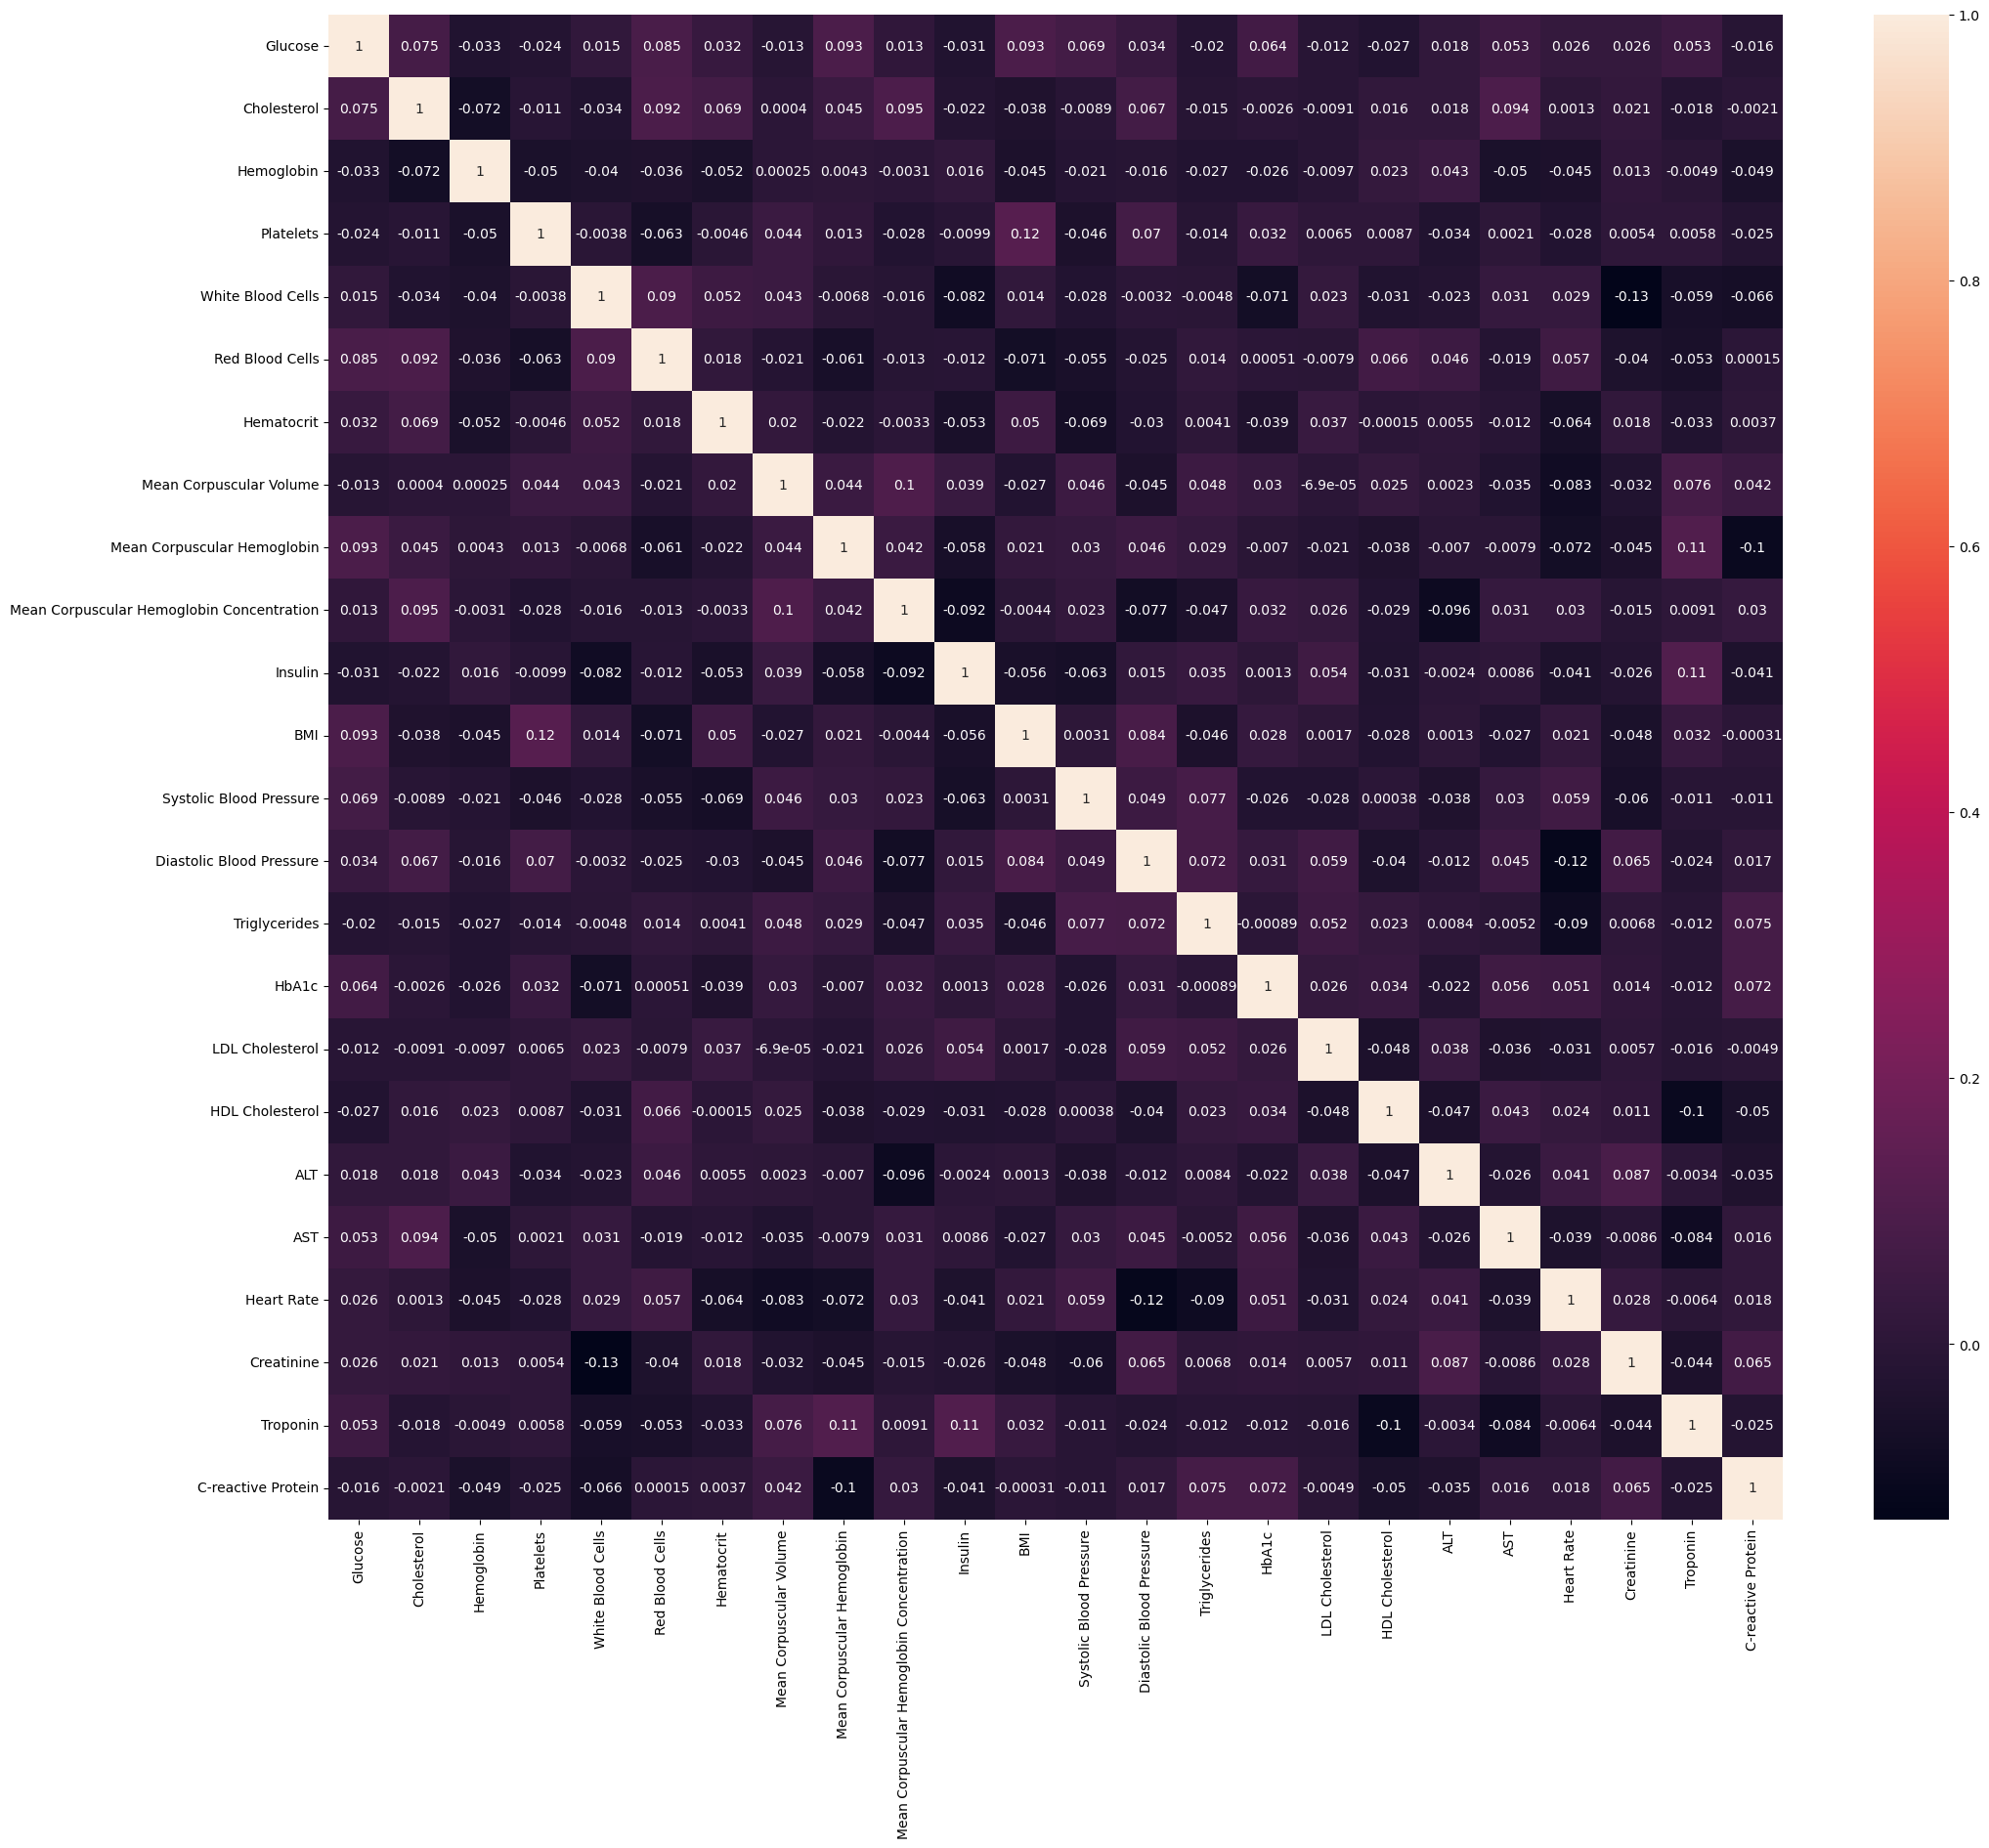

In [18]:
relations = continuous_features.corr()
plt.figure(figsize=(24,20))
sns.heatmap(data=relations, annot=True)

# This many columns perhaps indicates misleading correlations

# Histogram

/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_25521/2702308912.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_25521/2702308912.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_25521/2702308912.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_25521/2702308912.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_25521/2702308912.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_25521/2702308912.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_25521/27023

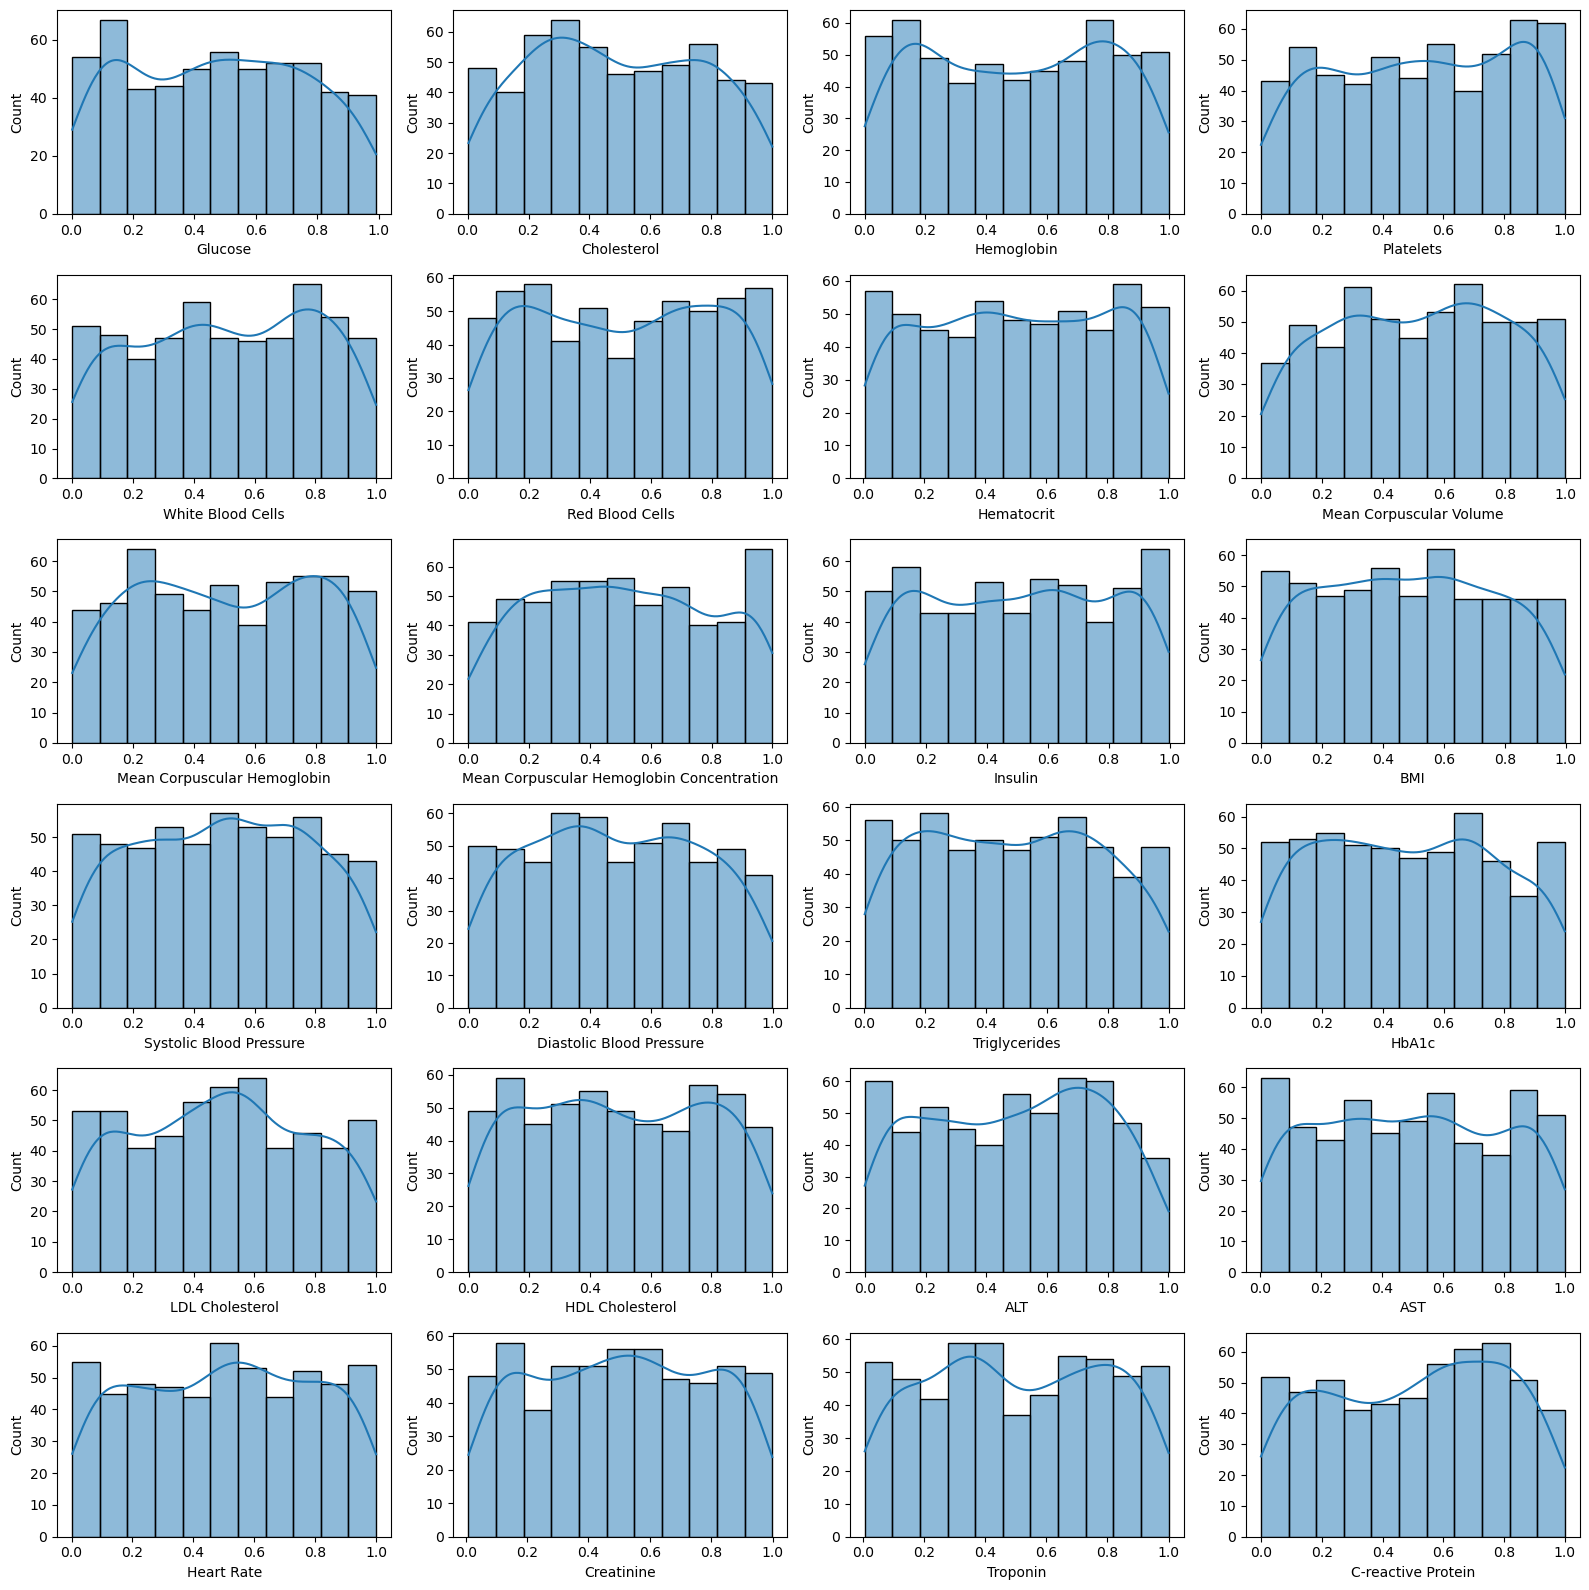

In [19]:
plt.figure(figsize=(16,16))
len_cols = len(continuous_features.columns)
rows = (len_cols +3)//4

for idx, col in enumerate(continuous_features.columns):
  plt.subplot(rows, 4, idx+1)
  sns.histplot(continuous_features[col], kde=True)
  plt.tight_layout()
  plt.plot()

# Boxplot

/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_25521/3197445724.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_25521/3197445724.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_25521/3197445724.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_25521/3197445724.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_25521/3197445724.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_25521/3197445724.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_25521/31974

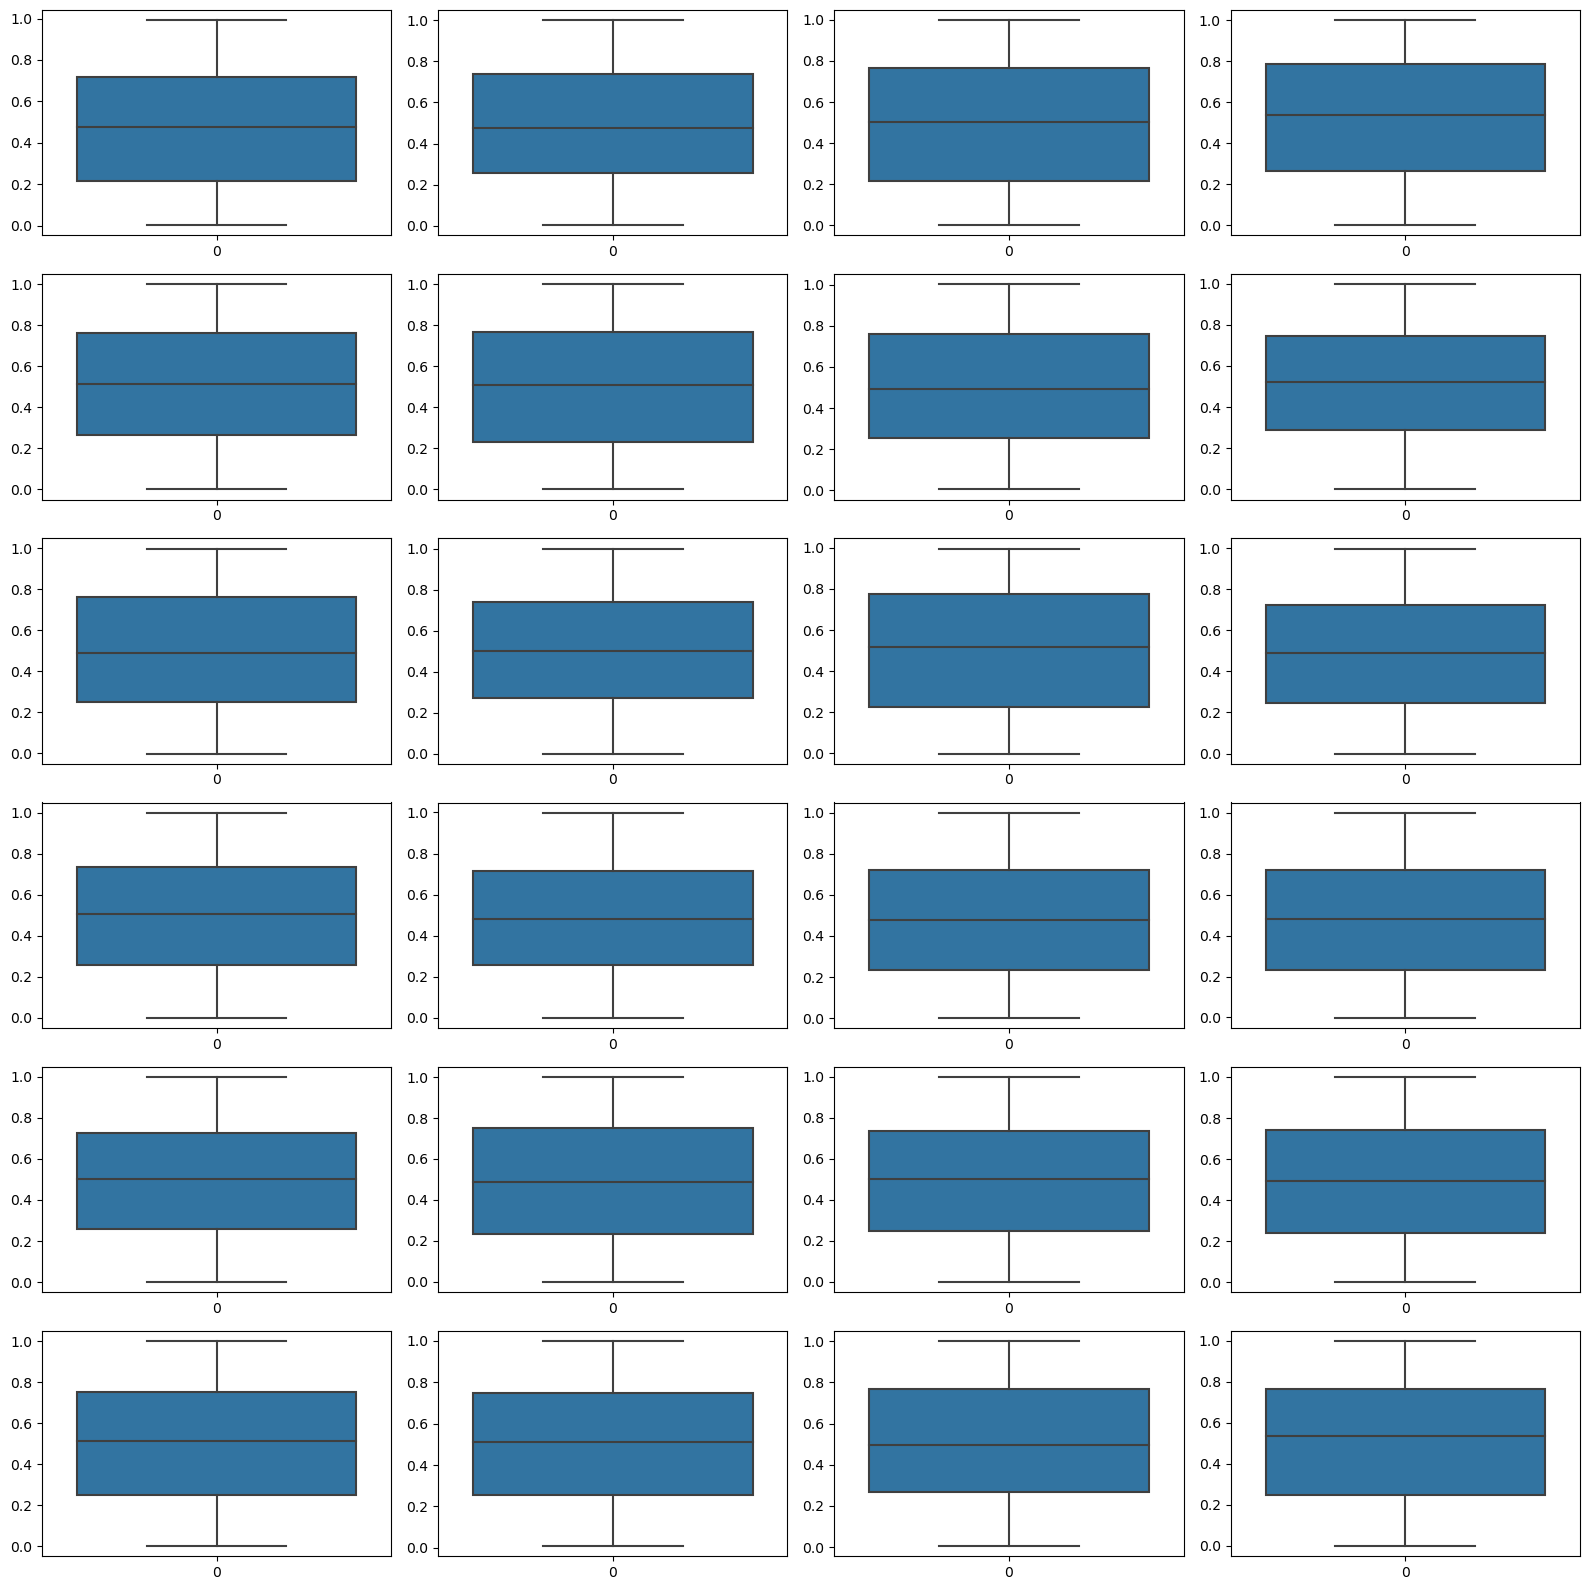

In [20]:
plt.figure(figsize=(16,16))
len_cols = len(continuous_features.columns)
rows = (len_cols +3)//4

for idx, col in enumerate(continuous_features.columns):
  plt.subplot(rows, 4, idx+1)
  sns.boxplot(continuous_features[col])
  plt.tight_layout()
  plt.plot()

In [21]:
df.describe()

,Glucose,Cholesterol,Hemoglobin,Platelets,White Blood Cells,Red Blood Cells,Hematocrit,Mean Corpuscular Volume,Mean Corpuscular Hemoglobin,Mean Corpuscular Hemoglobin Concentration,...,Triglycerides,HbA1c,LDL Cholesterol,HDL Cholesterol,ALT,AST,Heart Rate,Creatinine,Troponin,C-reactive Protein
count,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,...,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000
mean,0.475227,0.492663,0.497140,0.525250,0.510896,0.505118,0.503424,0.513888,0.505942,0.508695,...,0.484380,0.484786,0.491840,0.494617,0.493339,0.493360,0.504330,0.504560,0.504131,0.506518
std,0.283778,0.280406,0.297259,0.294051,0.289450,0.298614,0.293361,0.280083,0.289025,0.288803,...,0.288271,0.288209,0.283598,0.290773,0.283903,0.295811,0.289252,0.283292,0.290204,0.288271
min,0.001827,0.003088,0.000719,0.000006,-0.000206,0.000552,0.004556,0.000309,-0.000614,0.000719,...,0.001885,-0.000991,0.001036,-0.000546,-0.000312,0.002047,0.002145,0.008831,0.005714,-0.000991
25%,0.214954,0.257884,0.213650,0.264210,0.267207,0.231967,0.252711,0.287635,0.249905,0.273124,...,0.234539,0.233675,0.260311,0.235644,0.246601,0.239383,0.251697,0.254022,0.269927,0.250239
50%,0.475540,0.476706,0.504278,0.538172,0.514195,0.509668,0.494564,0.523925,0.492042,0.501131,...,0.478313,0.480594,0.502260,0.489317,0.502745,0.493548,0.515742,0.509323,0.495363,0.537822
75%,0.715584,0.739757,0.765690,0.786453,0.764330,0.765701,0.760481,0.746516,0.762454,0.738735,...,0.721330,0.719385,0.724031,0.750000,0.734460,0.743309,0.751903,0.746752,0.767972,0.764027
max,0.991742,0.999606,0.997876,0.999507,0.999646,1.000000,1.000857,0.996362,0.999234,0.999666,...,0.999826,0.999265,0.999567,1.000744,1.000326,1.000402,0.999857,0.999348,1.000125,0.999488


# Split up feature and target variables

In [22]:
X,y = df.drop("Disease", axis=1), df["Disease"]

# Encode Target Variable

In [23]:
from sklearn.calibration import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Feature Importance

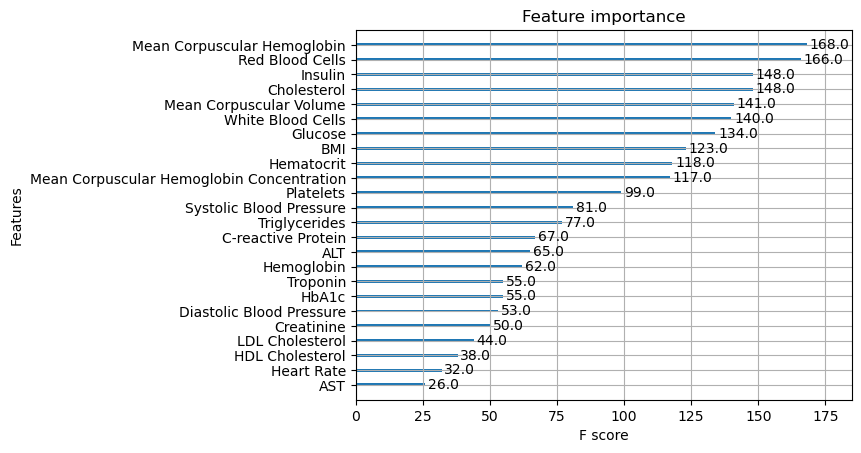

In [24]:
# fit model on training data
from xgboost import plot_importance
model = XGBClassifier()
model.fit(X, y)
# plot feature importance
plot_importance(model)
plt.show()

# Baseline Model Evaluation

In [28]:
from sklearn.metrics import accuracy_score
model = DummyClassifier(strategy='uniform')

metric = make_scorer(accuracy_score)
# evaluate the model
scores = evaluate_model(X, y, model, metric)
# summarize performance
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.154 (0.041)


# Spot Check Algorithms

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)
models = spot_check_models(X_train_scaled, X_test_scaled, y_train, y_test)
models

,Model,Accuracy
8,GradientBoostingClassifier,0.918919
6,DecisionTreeClassifier,0.909910
9,XGB,0.891892
7,RandomForestClassifier,0.882883
0,GaussianNB,0.639640
4,SVC,0.639640
1,LDA,0.621622
3,LogisticRegression,0.621622
5,KNeighborsClassifier,0.576577
2,GPC,0.522523


In [31]:
names = ["XGB", "DTC", "GBC", "RFC","SVC","LR"]
models = get_selected_models(names)

testing_selected_models(names, models, X, y, metric)

>XGB 0.917 (0.032)
>DTC 0.911 (0.032)
>GBC 0.907 (0.030)
>RFC 0.898 (0.043)
>SVC 0.633 (0.030)
>LR 0.617 (0.044)


# Hyper Parameter Tuning

Best score for XGB: 0.891
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200}
Test accuracy for XGB: 0.919
---------------------------------------------------------------


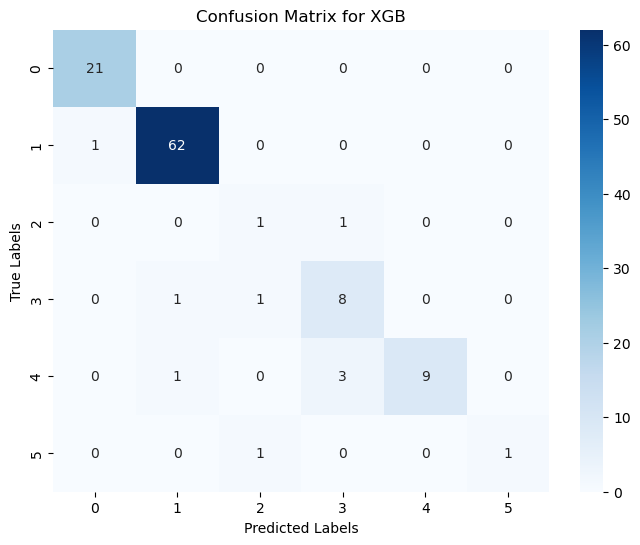

Best score for DTC: 0.898
Best parameters: {'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__splitter': 'best'}
Test accuracy for DTC: 0.946
---------------------------------------------------------------


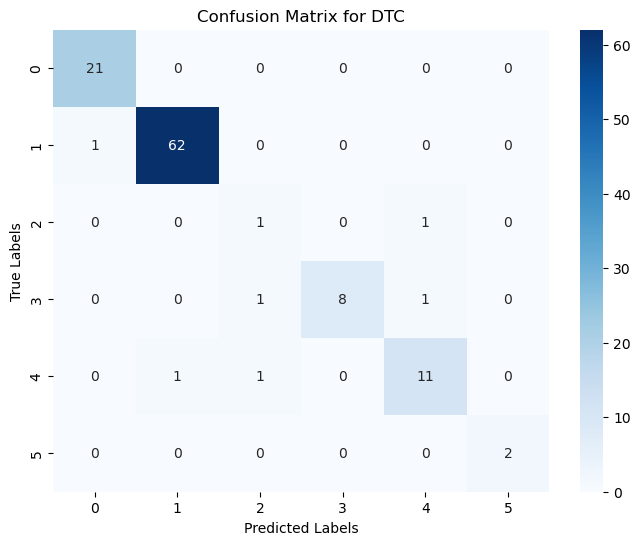

Best score for GBC: 0.877
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 300}
Test accuracy for GBC: 0.919
---------------------------------------------------------------


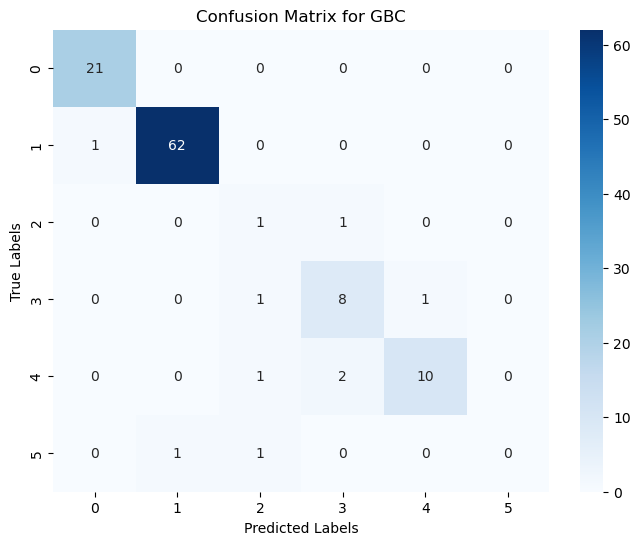

Best score for RFC: 0.850
Best parameters: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Test accuracy for RFC: 0.883
---------------------------------------------------------------


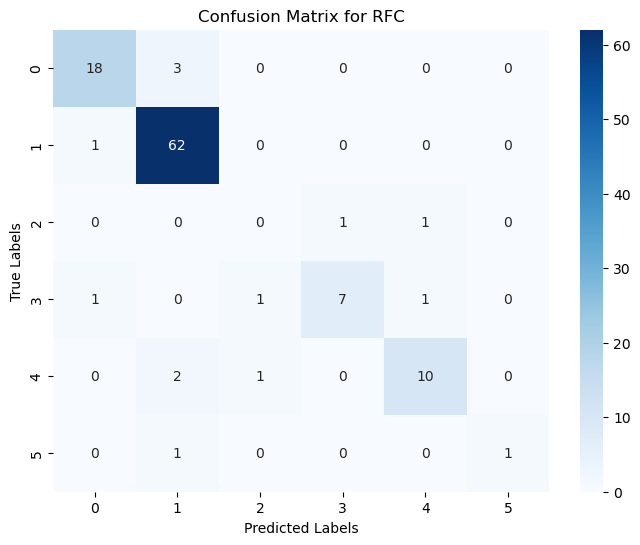

  Model  Best CV Score  Test Accuracy  \
0   XGB       0.890909       0.918919   
1   DTC       0.897727       0.945946   
2   GBC       0.877273       0.918919   
3   RFC       0.850000       0.882883   

                                     Best Parameters  
0  {'model__learning_rate': 0.1, 'model__max_dept...  
1  {'model__criterion': 'gini', 'model__max_depth...  
2  {'model__learning_rate': 0.1, 'model__max_dept...  
3  {'model__max_depth': 20, 'model__min_samples_l...  


In [32]:
names = ["XGB", "DTC", "GBC", "RFC"]
models = get_selected_models(names)

param_grid = {
  'DTC': {
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__splitter': ['best', 'random'] 
    },
    'RFC': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
    },
    'GBC': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    'XGB': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2]
    }
}
grid_search_selected_models(param_grid, names, models, X, y, metric)